In [37]:
import os
import time
import cv2
import pupil_apriltags
import numpy as np
import json
from AprilBoard import AprilBoard
import matplotlib.pyplot as plt


names = ["left", "back", "right"]
os.system("v4l2-ctl --list-devices")

def crop_image(image, bbox_str):
    """
    Crops an image based on a bounding box string format '[top:bottom,left:right]'.

    Args:
        image: A NumPy array representing the image.
        bbox_str: A string representing the bounding box in format '[top:bottom,left:right]'.

    Returns:
        A NumPy array representing the cropped image.
    """
    try:
        slices = bbox_str.strip('[]').split(',')
        top, bottom = map(int, slices[0].split(':'))
        left, right = map(int, slices[1].split(':'))
    except ValueError:
        raise ValueError('Invalid bounding box format. Use [top:bottom,left:right]')

    # Crop the image
    return image[top:bottom, left:right]


def point(pt):
    return (int(pt[0]),int(pt[1]))

def draw_detection(img, detection, color=(255,0,0)):
    pt1 = point(detection.corners[0])
    cv2.circle(img, pt1,5,color,-1)
    pt2 = point(detection.corners[1])
    cv2.line(img, pt1, pt2,color,2)
    pt3 = point(detection.corners[3])
    cv2.line(img, pt1, pt3,color,2)
    c = point(detection.center)
    cv2.circle(img, c,2,color,-1)
    cv2.putText(img,str(detection.tag_id), c, cv2.FONT_HERSHEY_PLAIN, 1.5,color,2)

images = []
calibration_data = {}

def get_images(dir = '.'):
    allfiles = os.listdir(dir)
    images = []
    for f in allfiles:
        if "unwarped" in f:
            continue
        if ".jpg" in f:
            images.append(os.path.join(dir,f))
    return images

class Camera:
    def __init__(self, id, name, live=True, dir='.'):
        self.id = id
        self.name = name
        self.frame = None
        if live:
            cmd = f"v4l2-ctl --device /dev/video{id} --set-standard=ntsc"
            os.system(cmd)
            self.cap = cv2.VideoCapture(id)
            self.cap.set(3, 720)
            self.cap.set(4, 480)
            self.ret, self.frame = self.cap.read()
        self.load_intrinsics(dir)
        self.map1 = None
        self.map2 = None
        self.frame_unwarpped = None

    def load_intrinsics(self, dir):
        allfiles = os.listdir(dir)
        self.intrinsics = {}
        for f in allfiles:
            if 'intrinsics' in f:
                if self.name in f:
                    with open(f,'r') as fp:
                        self.intrinsics = json.load(fp)

    def from_img(self, img):
        if self.intrinsics == {}:
            self.load_intrinsics('.')
        crop = self.intrinsics['crop']
        self.frame = crop_image(img, crop)

    def detect(self, detector, draw=False):
        gray = cv2.cvtColor(self.frame, cv2.COLOR_BGR2GRAY)
        result = detector.detect(gray)

        for detection in result:
            if draw:
                draw_detection(self.frame, detection,(0,255,0))
    
    def unwarp(self):
        if self.map1 is None:
            K = np.array(self.intrinsics['matrix'])
            D = np.array(self.intrinsics['distortion'])
            fisheyeMode = self.intrinsics['fisheye']

            if fisheyeMode:
                self.map1, self.map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, (self.frame.shape[1], self.frame.shape[0]), cv2.CV_16SC2)
            else:
                self.map1, self.map2 = cv2.initUndistortRectifyMap(K, D, np.eye(3), K, (self.frame.shape[1], self.frame.shape[0]), cv2.CV_16SC2)
        self.frame_unwarpped = cv2.remap(self.frame, self.map1, self.map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
        return self.frame_unwarpped

    def get_frame(self):
        self.ret, self.frame = self.cap.read()
        return self.frame

    def release(self):
        self.cap.release()

UNKNOWN/GENERIC (PCI:0000:02:01.0):
	/dev/video0
	/dev/vbi0
	/dev/media0

UNKNOWN/GENERIC (PCI:0000:02:05.0):
	/dev/video1
	/dev/vbi1
	/dev/media1

UNKNOWN/GENERIC (PCI:0000:02:09.0):
	/dev/video2
	/dev/vbi2
	/dev/media2

UNKNOWN/GENERIC (PCI:0000:02:0d.0):
	/dev/video3
	/dev/vbi3
	/dev/media3



Standard set to 0000b000
Standard set to 0000b000
Standard set to 0000b000
Frame saved to frame_1710703144.jpg size:(480, 2160, 3)


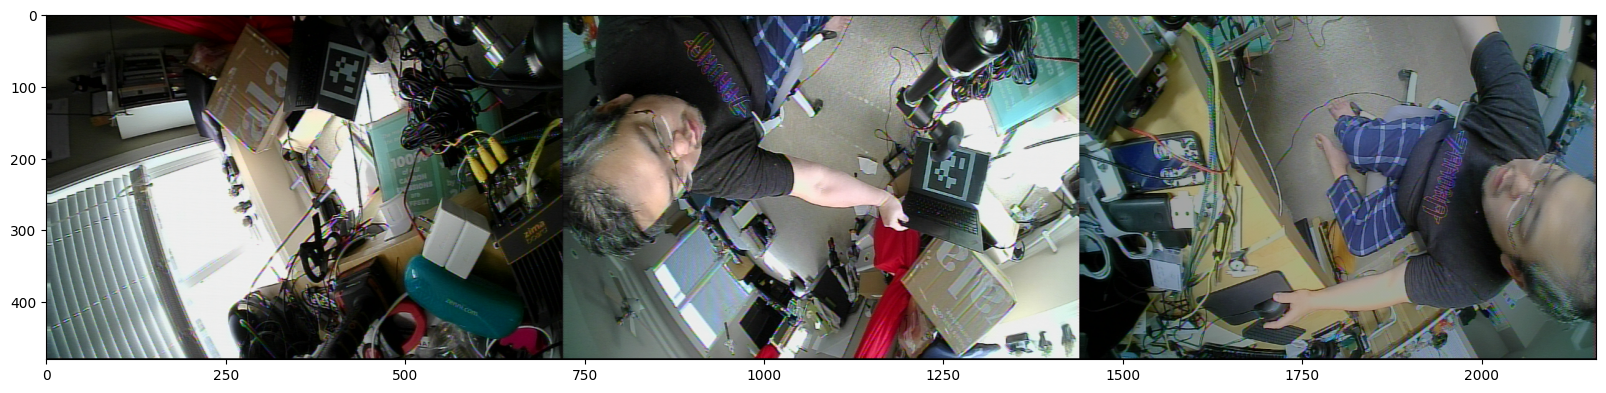

In [30]:
#capture frame from each camera and conceate into one image
cameras = [Camera(i, name) for i, name in enumerate(names)]
save = True
unwarp = False
for cam in cameras:
    cam.get_frame()
    if unwarp:
        cam.load_intrinsics('.')
        cam.unwarp()

frame_combined = cv2.hconcat([ cam.frame_unwarpped if unwarp else cam.frame for cam in cameras])

# save image to disk
if save:
    filename = f"frame_{int(time.time())}.jpg"
    cv2.imwrite(filename, frame_combined)
    print(f"Frame saved to {filename} size:{frame_combined.shape}")

# Display the image
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(frame_combined, cv2.COLOR_BGR2RGB))
plt.show()

# Release the video capture object and close any open windows
for cam in cameras:
    cam.release()



In [ ]:
# rectify stored images

names = ["left", "back", "right"]
dir = '.'
allfiles = os.listdir(dir)
images = []
calibration_data = {}
for f in allfiles:
    if "unwarped" in f:
        continue
    if ".jpg" in f:
        images.append(os.path.join(dir,f))

    if 'intrinsics' in f:
        for n in names:
            if n in f:
                with open(f,'r') as fp:
                    calibration_data[n] = {'intrinsics':json.load(fp)}

board = AprilBoard.AprilBoard()
detector = pupil_apriltags.Detector()
images_unwarped = []

for path in images:
    print(path)
    img_raw = cv2.imread(path)

    views = []
    for i in range(len(names)):
        name = names[i]

        K = np.array(calibration_data[name]['intrinsics']['matrix'])
        D = np.array(calibration_data[name]['intrinsics']['distortion'])
        fisheyeMode = calibration_data[name]['intrinsics']['fisheye']
        flip = calibration_data[name]['intrinsics']['flip']
        crop = calibration_data[name]['intrinsics']['crop']
        img = crop_image(img_raw, crop)
        if flip:
            img = cv2.flip(img, 1)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        result = detector.detect(gray)

        for detection in result:
            draw_detection(img, detection,(0,255,0))
        if 'map1' not in calibration_data[name]:
            if fisheyeMode:
                calibration_data[name]['map1'], calibration_data[name]['map2'] = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, (img.shape[1], img.shape[0]), cv2.CV_16SC2)
            else:
                calibration_data[name]['map1'], calibration_data[name]['map2'] = cv2.initUndistortRectifyMap(K, D, np.eye(3), K, (img.shape[1], img.shape[0]), cv2.CV_16SC2)
        img2 = cv2.remap(img, calibration_data[name]['map1'], calibration_data[name]['map2'], interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
        views.append(img2)

    img_concat = cv2.hconcat(views)
    images_unwarped.append(img_concat)


#show grid of images in unwarped 4 columns no margin
cols = 2
rows = int(len(images_unwarped)/cols)
fig, ax = plt.subplots(rows, cols, figsize=(cols*6*3, rows*4))

# Remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(cv2.cvtColor(images_unwarped[i*cols+j], cv2.COLOR_BGR2RGB))
        ax[i,j].axis('off')

plt.show()



Standard set to 0000b000
Standard set to 0000b000
Standard set to 0000b000


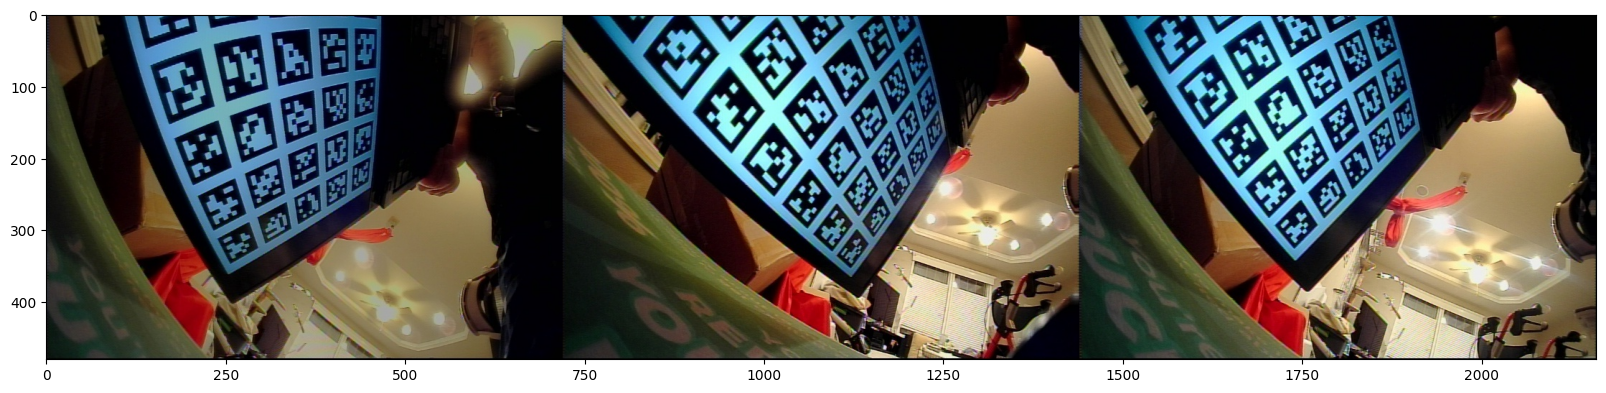

In [40]:
dir = '.'
images = get_images(dir)
cameras = [Camera(i, name, live=False) for i, name in enumerate(names)]
img = cv2.imread(images[0])
for cam in cameras:
    cam.from_img(img)

frame_combined = cv2.hconcat([cam.frame for cam in cameras])
# Display the image
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(frame_combined, cv2.COLOR_BGR2RGB))
plt.show()

# Release the video capture object and close any open windows
# for cam in cameras:
#     cam.release()

